$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Bilinear Extended Dynamic Mode Decomposition 

### System dynamics: system with finite dimensional Koopman canonical transform

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} \lambda x_1 \\ \mu x_2 + (2 \lambda - \mu) c x_1^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ x_1+1 \end{bmatrix}, \qquad
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [\mb q \, \mb{\dot{q}}]^T$, these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield


\begin{equation}
\mb D(\mb q) = (\mb q+1)^{-1}, \qquad \mb C(\mb q, \mb{\dot{q}}) = \mu (\mb q+1)^{-1}, \qquad \mb G(\mb q) = (2\lambda - \mu)c \mb q^2 (\mb q + 1)^{-1}, \qquad \mb B = 1,
\end{equation}

In [1]:
import numpy as np

from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 1, 1)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([(q+1)**(-1)])
    
    def C(self, q, q_dot):
        _, mu, _ = self.params
        return np.array([mu*(q+1)**(-1)])
    
    def G(self, q):
        lambd, mu, c = self.params
        return np.array([(2*lambd -mu)*c*q**(2)*(q+1)**(-1)])
    
    def B(self, q):
        return np.array([[1]])
    
lambd, mu, c = -.3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} \mb q\\
    \mb{\dot{q}}- c \mb q^2\\
    \mb q^2\\
    1
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4$ are eigenfunctions of the Koopman operator associated with the drift vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal element is $F=\text{diag}(\lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have:

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ \mb q + 1 \\ 0 \\ 0 \end{bmatrix}, 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G\mb z u$ with

\begin{equation}
F = \begin{bmatrix} \lambda & 0 & 0 & 0\\
0 & \mu & 0 & 0\\
0 & 0 & 2 \lambda & 0\\
0 & 0 & 0 & 0\\  
\end{bmatrix}, \qquad 
G = \begin{bmatrix} 0 & 0 & 0 & 0\\
1 & 0 & 0 & 1\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [2]:
from koopman_core.dynamics.bilinear_dynamics import BilinearDynamics

F = np.array([[lambd, 0, 0, 0], [0, mu, 0, 0], [0, 0, 2*lambd, 0], [0, 0, 0, 0]])
G = [np.array([[0, 0, 0, 0], [1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])]
C_h = np.array([1, 0, 0, 0])
phi_fun = lambda x: np.array([x[0], x[1] - c*x[0]**2, x[0]**2, 1])
n, m = 4, 1

koop_bilinear_sys = BilinearDynamics(n, m, F, G, phi_fun)


### Collect data from the system under PD control

We first collect data from the system under PD control designed by LQR on the linearization of the dynamics around the 
origin. This is done by picking 20 intial conditions $\mb x_0 = [q_0, \dot{q}_0]^T$ uniformly at random in the space 
$\mb x_0 \in [-5, 5]^2$. The linearized dynamics around the origin are:

\begin{equation}
    \mb{\dot{x}} = \begin{bmatrix} \lambda & 0\\ 0 & \mu \end{bmatrix} \mb x + 
    \begin{bmatrix} 0 \\ 1 \end{bmatrix} u
\end{equation}

and using these dynamics, we can design a LQR controller as follows:

In [3]:
from scipy.linalg import solve_continuous_are
from core.controllers.pd_controller import PDController

n, m = 2, 1
A = np.array([[lambd, 0],[0, mu]])
B = np.array([[0],[1]])
q, r = 20, 1
Q_lqr = q*np.eye(n)
R_lqr = r*np.eye(m)
P = solve_continuous_are(A, B, Q_lqr, R_lqr)
K = -np.linalg.inv(R_lqr)@B.T@P
print(K)

lqr_controller = PDController(finite_dim_koop_sys, K[:,:int(n/2)], K[:,int(n/2):])

[[ 1.08812061e-17 -4.67660586e+00]]


Finally, we collect the data and store the state and action pairs that will be used to learn dynamics models later on:

[-0.09631006 -0.35045648]


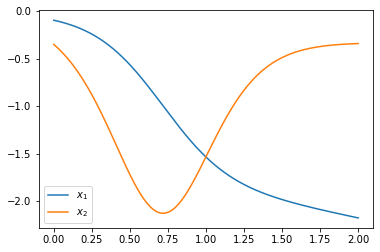

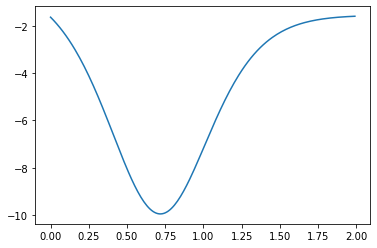

In [ ]:
import random as rn
from koopman_core.controllers.perturbed_controller import PerturbedController
from matplotlib import pyplot as plt

Ntraj = 2                                                  # Number of trajectories to collect data from
dt = 1.0e-2                                                 # Time step length
N = int(2./dt)                                              # Number of time steps
t_eval = dt * np.arange(N + 1)                              # Simulation time points
traj_bounds = [0.5, 0.5]                                        # State constraints, [q, q_dot]
pert_noise_var = 0.0                                        # Variance of controller perturbation noise

pert_lqr_controller = PerturbedController(finite_dim_koop_sys, lqr_controller, pert_noise_var)

xs, us, us_nom, ts = [], [], [], []
for ii in range(Ntraj):
    x_0 = np.asarray([rn.uniform(-i,i)  for i in traj_bounds])
    xs_tmp, us_tmp = finite_dim_koop_sys.simulate(x_0, pert_lqr_controller, t_eval)
    xs.append(xs_tmp)
    us.append(us_tmp)
    ts.append(t_eval)
    
    print(x_0 )
    plt.figure()
    plt.plot(t_eval, xs_tmp[:,0], label='$x_1$')
    plt.plot(t_eval, xs_tmp[:,1], label='$x_2$')
    plt.legend()
    
    plt.figure()
    plt.plot(t_eval[:-1], us_tmp[:,0], label='$u$')
    plt.show()

xs, us, ts = np.array(xs), np.array(us), np.array(ts)


### Learn lifted linear state space model with EDMD

### Learn lifted bilinear state space model with bEDMD

### Compare prediction performance of the linear and bilinear models